# Training: Curriculum

#### 1) Train on various close-to-terminal standard situations
#### 2) Train on self-play episodes of the champion
#### 3) Avoid frustrating the freshling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import random

import numpy as np

from aegomoku.game_data import read_training_data
from aegomoku.trainer import Trainer, create_curriculum, TERMINAL_OPPORTUNITY, TERMINAL_THREAT, ENDGAME, ALL_GAMEPLAY
from aegomoku.game_data import create_dataset
from aegomoku.utils import analyse_example
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2022-09-09 16:33:18.677968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:33:18.678655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:33:18.684095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:33:18.684827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 16:33:18.685664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BOARD_SIZE = 15

---

# Read curriculum game data

### Pickle files
Pickle files contain only single representatives of the 8 symmetries and the board positions are represented by the list of integers for the stones instead of the canonical N x X x 3 representation

In [4]:
source = os.listdir('../DATA')
print(os.getcwd())
print(source)

/home/wgiersche/workspace/Project-Ellie/DeepGomoku/notebooks
['00005.pickle', '00011.pickle', '00003.pickle', '00009.pickle', '00007.pickle', '00010.pickle', '00012.pickle', '00006.pickle', '00008.pickle', '00001.pickle', '00002.pickle', '00004.pickle']


### Preprocess to tf-friendly TFRecords

`to_tfrecord()` expands the 8 symmetries and writes the result as tfrecord files for efficient consumption by Tensorflow. Since the preprocessing is relatively inexpensive, we locate the tfrecords in a temporary directory that we clean up afterwards.

In [1]:
!pwd

/home/wgiersche/workspace/Project-Ellie/DeepGomoku/notebooks


In [5]:
data_dir = '../DATA'
curriculum = create_curriculum(data_dir, 1024, TERMINAL_OPPORTUNITY)

Preparing course: Terminal Opportunities


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Prepared course: Terminal Opportunities: 3008 examples



## Terminal Opportunities

Next to play: WHITE
Value from WHITE's point of view: 1.0


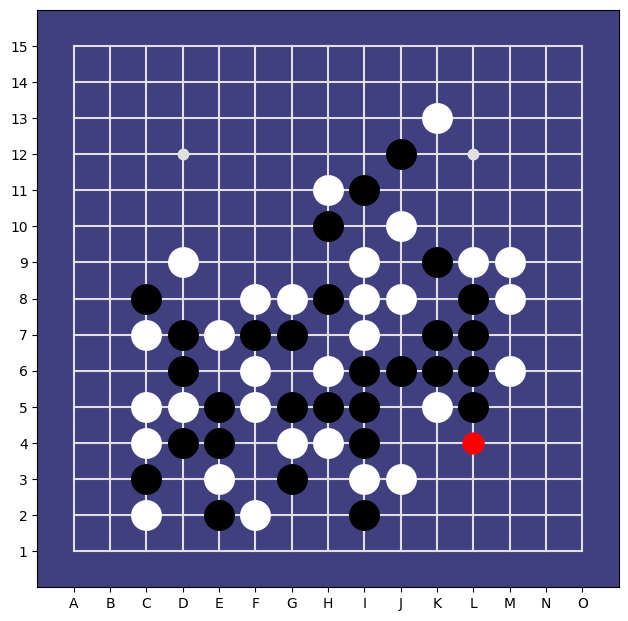

In [9]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Terminal Threats

Next to play: BLACK
Value from BLACK's point of view: -0.999536395072937


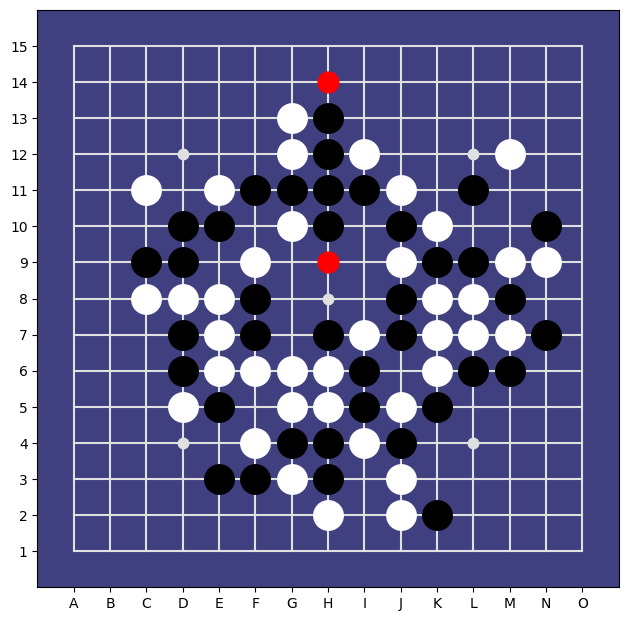

In [146]:
ds = curriculum[TERMINAL_THREAT]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Endgame

Next to play: BLACK
Value from BLACK's point of view: -0.8513492941856384


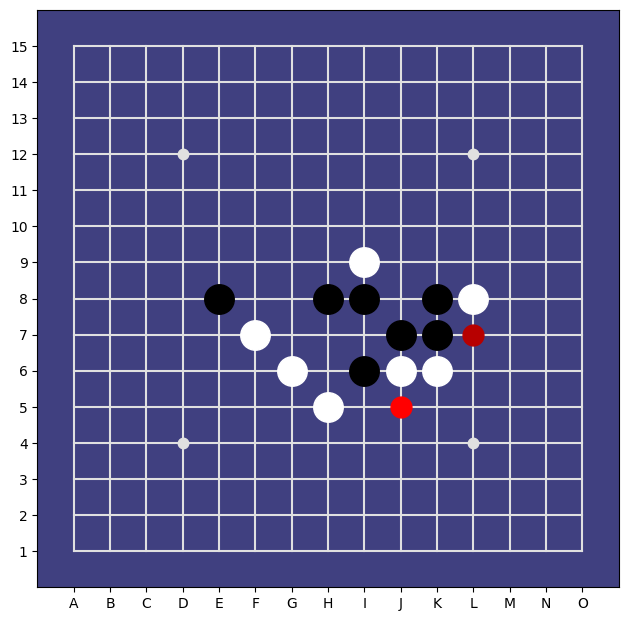

In [147]:
ds = curriculum[ENDGAME]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## General Gameplay

Next to play: WHITE
Value from WHITE's point of view: -0.008902051486074924


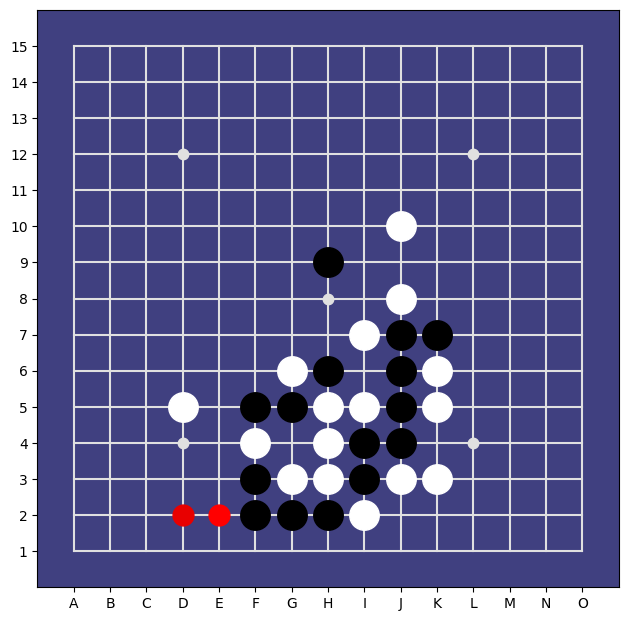

In [148]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

---


## Warm up, then train fully
We use a first curriculum of smaller datasets to initiate the fresh network

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=1024, num_blocks=20)
model.compile()
model.summary()

In [ ]:
trainer = Trainer(model)

In [ ]:
ds = curriculum[ENDGAME]['dataset']
trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)

In [ ]:
model.save('models/from_endgame.model')

## All game play
This will last for a couple of hours

In [ ]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

In [ ]:
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned)

In [ ]:
trainer.train(ds, epochs_per_train=1000, report_every=5, v_weight=1.0)

In [ ]:
model.save('models/1_c1.model')

In [ ]:
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]

In [ ]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example(BOARD_SIZE, (s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned, disp_width=5)

## Compare new policy with the MCTS evaluations

In [6]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model("models/1_c1.model/")

Next to play: BLACK
Value from BLACK's point of view: 0.5450474619865417
Next to play: BLACK
Value from BLACK's point of view: 0.29977959394454956


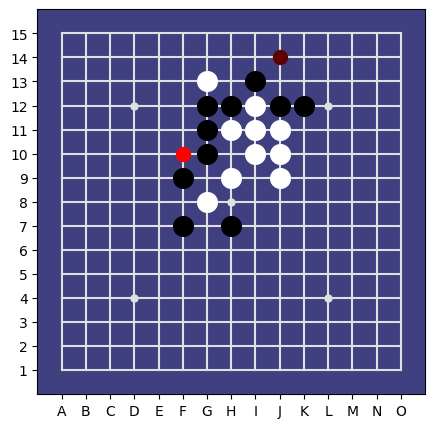

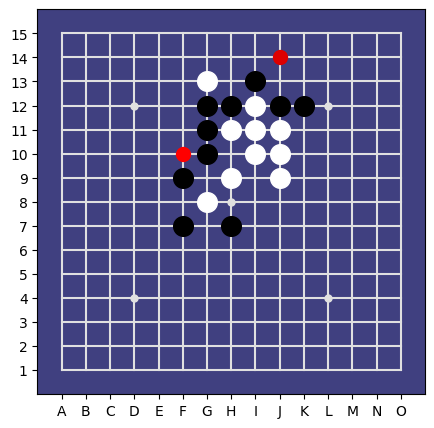

In [27]:
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example(BOARD_SIZE, (s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned, disp_width=5)

## Killing Inhibition?

In [6]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]
from aegomoku.utils import analyse_example
model = tf.keras.models.load_model("models/1_c1.model/")

Next to play: WHITE
Value from WHITE's point of view: 1.0
Next to play: WHITE
Value from WHITE's point of view: 0.9992259740829468


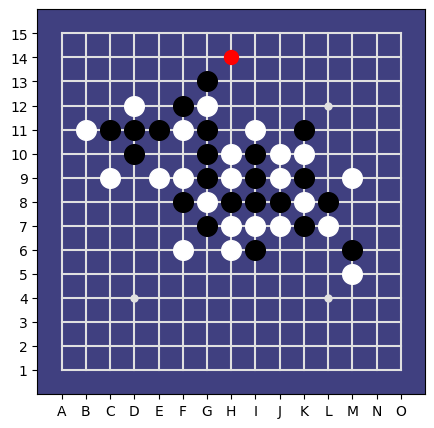

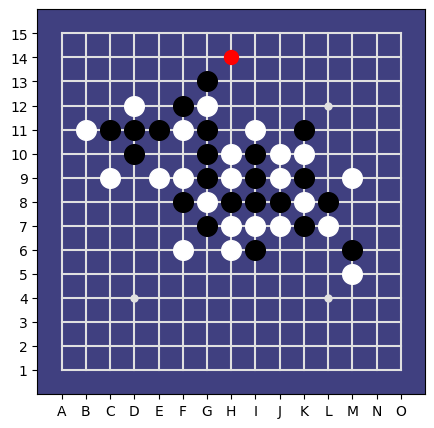

In [33]:
import random
n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example(BOARD_SIZE, (s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned, disp_width=5)

## 1.  Refinement: Overcome the killing inhibition

Focus on terminal opportunities: Very little error is acceptable for these conditions

In [63]:
new_model = tf.keras.models.load_model("models/1_c1.model/")

In [64]:
trainer = Trainer(new_model)

In [65]:
ds = curriculum[TERMINAL_OPPORTUNITY]['dataset']
trainer.train(ds, epochs_per_train=5, report_every=1, v_weight=1.0)

Epoch: 1, Training: p: 0.1323763, v: 0.00726073 - elapsed: 4.78s
Epoch: 2, Training: p: 0.1164276, v: 0.004840488 - elapsed: 1.0614s
Epoch: 3, Training: p: 0.1021271, v: 0.003630379 - elapsed: 1.0383s
Epoch: 4, Training: p: 0.09029301, v: 0.002904308 - elapsed: 1.048s
Epoch: 5, Training: (0.090293005, 0.002904308)


In [66]:
new_model.save('models/1_c2.model')

INFO:tensorflow:Assets written to: models/1_c2.model/assets


INFO:tensorflow:Assets written to: models/1_c2.model/assets


In [1]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example(BOARD_SIZE, (s, p, v), disp_width=5)

# Learned
p_learned, v_learned = new_model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned, disp_width=5)

NameError: name 'random' is not defined

In [ ]:
filenames = ["trajectories/mcts/the_heuristic_200.pickle",
             "trajectories/policy/terminal_opportunities.pickle",
             "trajectories/policy/terminal_threats.pickle"]

# Number of training samples from each course
N_warmup = [1000, 1000, 1000]
N_main = [20000, 2000, 4000]

curriculum = [read_training_data(filename, BOARD_SIZE) for filename in filenames]
datasets_warmup = []
datasets_main = []
for i in range(len(filenames)):
    examples = curriculum[i]
    datasets_warmup.append(create_dataset(examples[:N_warmup[i]]))
    datasets_main.append(create_dataset(examples[:N_main[i]]))

for i, course in enumerate(curriculum):
    print(filenames[i])
    print(len(course), len(course[0]), course[0][0].shape)

## A quick peek into the course material

In [ ]:
for i, course in enumerate(curriculum):
    print(filenames[i])
    analyse_example(BOARD_SIZE, course[random.randint(0, len(course))], disp_width=3)

---

# Construct a fresh model

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

## Terminal Threats

Next to play: BLACK
Value from BLACK's point of view: -0.9992791414260864


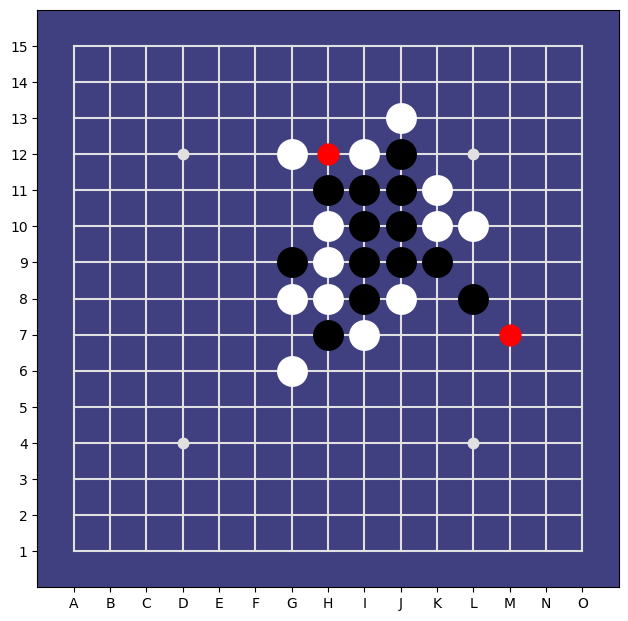

In [7]:
ds = curriculum[Focus.TERMINAL_THREAT]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Endgame

Next to play: WHITE
Value from WHITE's point of view: -0.9164876341819763


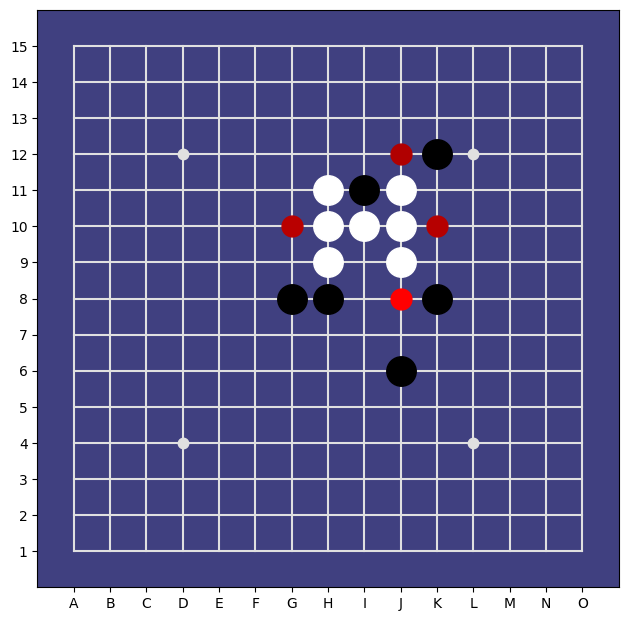

In [8]:
ds = curriculum[Focus.ENDGAME]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## General Gameplay

Next to play: WHITE
Value from WHITE's point of view: -0.049865204840898514


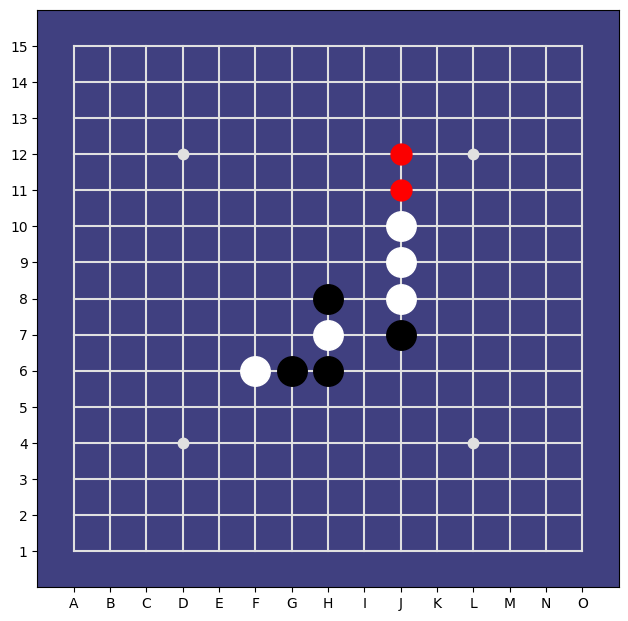

In [10]:
ds = curriculum[ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

In [10]:
from aegomoku.utils import stones_from_example
stones, winner = stones_from_example(example)
from aegomoku.gomoku_board import GomokuBoard
board = GomokuBoard(15, stones)
board.plot()
from aegomoku.gomoku_game import GomokuGame
game = GomokuGame(15)
game.get_winner(board) or "No winner yet."

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  O [X] X  .  .  .  .  .  .  .  .    
10    .  .  .  .  X  X  O  .  .  .  .  .  .  .  .    
 9    .  .  .  .  X  O  O  O  .  X  .  .  .  .  .    
 8    .  .  .  O  X  X  O  X  O  O  .  .  .  .  .    
 7    .  .  .  .  .  X  X  O  X  .  .  .  .  .  .    
 6    .  .  .  .  O  X  O  O  .  X  .  .  .  .  .    
 5    .  .  .  .  .  O  .  X  .  .  O  .  .  .  .    
 4    .  .  .  .  X  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O


/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
2022-09-06 21:54:07.632055: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-06 21:54:07.818262: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


'No winner yet.'

---

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=1024, num_blocks=20)
model.compile()
model.summary()

In [ ]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [ ]:
ds = curriculum[ENDGAME]['dataset']
trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)

In [ ]:
model.save('models/from_endgame.model')

In [ ]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

In [ ]:
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned)

In [ ]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
trainer.train(ds, epochs_per_train=1000, report_every=5, v_weight=1.0)

In [ ]:
model.save('models/1_c1.model')

In [ ]:
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]

In [ ]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example(BOARD_SIZE, (s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned, disp_width=5)

In [ ]:
filenames = ["trajectories/mcts/the_heuristic_200.pickle",
             "trajectories/policy/terminal_opportunities.pickle",
             "trajectories/policy/terminal_threats.pickle"]

# Number of training samples from each course
N_warmup = [1000, 1000, 1000]
N_main = [20000, 2000, 4000]

curriculum = [read_training_data(filename, BOARD_SIZE) for filename in filenames]
datasets_warmup = []
datasets_main = []
for i in range(len(filenames)):
    examples = curriculum[i]
    datasets_warmup.append(create_dataset(examples[:N_warmup[i]]))
    datasets_main.append(create_dataset(examples[:N_main[i]]))

for i, course in enumerate(curriculum):
    print(filenames[i])
    print(len(course), len(course[0]), course[0][0].shape)

## A quick peek into the course material

In [ ]:
for i, course in enumerate(curriculum):
    print(filenames[i])
    analyse_example(BOARD_SIZE, course[random.randint(0, len(course))], disp_width=3)

---

# Construct a fresh model

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

## Terminal Threats

In [ ]:
ds = curriculum[.TERMINAL_THREAT]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Endgame

In [ ]:
ds = curriculum[Focus.ENDGAME]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## General Gameplay

In [ ]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

In [ ]:
from aegomoku.utils import stones_from_example
stones, winner = stones_from_example(example)
from aegomoku.gomoku_board import GomokuBoard
board = GomokuBoard(15, stones)
board.plot()
from aegomoku.gomoku_game import GomokuGame
game = GomokuGame(15)
game.get_winner(board) or "No winner yet."

---

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

In [13]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [14]:
ds = curriculum[Focus.ENDGAME]['dataset']
trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)

2022-09-07 06:20:55.045734: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-07 06:20:55.286390: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch: 1, Training: p: 4.870449, v: 0.7929547 - elapsed: 11.938s
Epoch: 2, Training: p: 4.477837, v: 0.7936494 - elapsed: 2.8969s
Epoch: 3, Training: p: 4.085176, v: 0.7928767 - elapsed: 2.8996s
Epoch: 4, Training: p: 3.767072, v: 0.7929161 - elapsed: 2.8899s
Epoch: 5, Training: p: 3.527503, v: 0.792649 - elapsed: 2.8979s
Epoch: 6, Training: p: 3.344425, v: 0.7923374 - elapsed: 2.9184s
Epoch: 7, Training: p: 3.199464, v: 0.7920011 - elapsed: 2.9015s
Epoch: 8, Training: p: 3.082204, v: 0.7915943 - elapsed: 2.9389s
Epoch: 9, Training: p: 2.984467, v: 0.791238 - elapsed: 2.9417s
Epoch: 10, Training: (2.9844668, 0.79123795)


In [19]:
model.save('models/from_endgame.model')

INFO:tensorflow:Assets written to: models/from_endgame.model/assets


INFO:tensorflow:Assets written to: models/from_endgame.model/assets


Next to play: BLACK
Value from BLACK's point of view: -0.007615046110004187


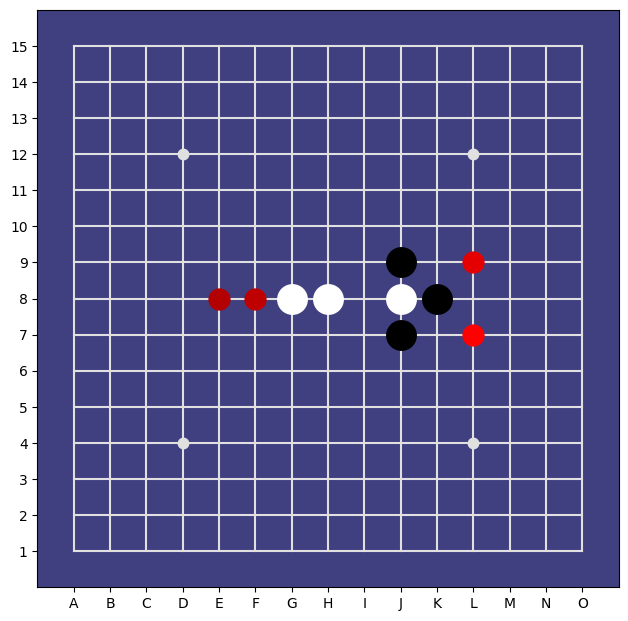

In [49]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

Next to play: BLACK
Value from BLACK's point of view: 0.8175955414772034


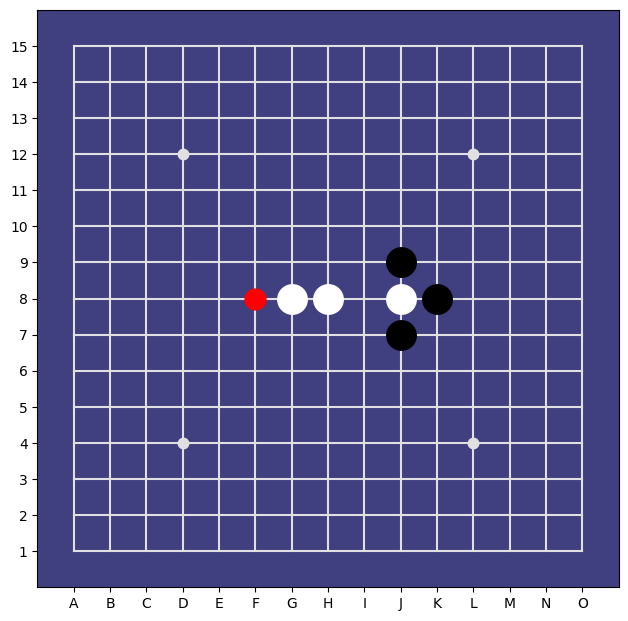

In [50]:
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned)

In [15]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
trainer.train(ds, epochs_per_train=1000, report_every=5, v_weight=1.0)

Epoch: 5, Training: p: 1.681218, v: 0.1419439 - elapsed: 405.89s
Epoch: 10, Training: p: 1.586996, v: 0.1316657 - elapsed: 338.12s
Epoch: 15, Training: p: 1.525364, v: 0.123661 - elapsed: 338.91s
Epoch: 20, Training: p: 1.48014, v: 0.1176634 - elapsed: 337.81s
Epoch: 25, Training: p: 1.444545, v: 0.1126297 - elapsed: 338.34s
Epoch: 30, Training: p: 1.415053, v: 0.1085954 - elapsed: 338.22s
Epoch: 35, Training: p: 1.389527, v: 0.1052435 - elapsed: 338.62s
Epoch: 40, Training: p: 1.367065, v: 0.1024754 - elapsed: 338.56s
Epoch: 45, Training: p: 1.346951, v: 0.1000982 - elapsed: 338.05s
Epoch: 50, Training: p: 1.328851, v: 0.09800452 - elapsed: 337.83s
Epoch: 55, Training: p: 1.312582, v: 0.09615032 - elapsed: 337.43s
Epoch: 60, Training: p: 1.297679, v: 0.0944097 - elapsed: 337.5s
Epoch: 65, Training: p: 1.28402, v: 0.09277167 - elapsed: 337.77s
Epoch: 70, Training: p: 1.271483, v: 0.0912365 - elapsed: 337.53s
Epoch: 75, Training: p: 1.259864, v: 0.08976626 - elapsed: 338.97s
Epoch: 80, 

KeyboardInterrupt: 

In [16]:
model.save('models/1_c1.model')

INFO:tensorflow:Assets written to: models/1_c1.model/assets


INFO:tensorflow:Assets written to: models/1_c1.model/assets


In [19]:
a_batch = next(iter(ds))
batch_size = a_batch[0].shape[0]

Next to play: WHITE
Value from WHITE's point of view: 0.9990121722221375
Next to play: WHITE
Value from WHITE's point of view: 0.10498829931020737


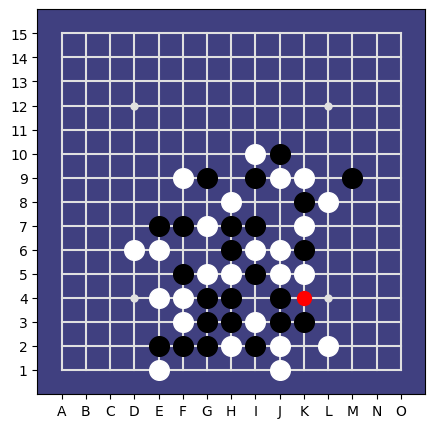

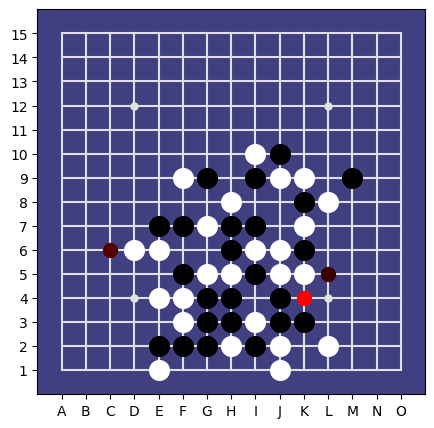

In [65]:
from aegomoku.utils import analyse_example

n = random.randint(0, batch_size)
s, p, v = np.expand_dims(a_batch[0][n,:,:,:], axis=0), list(a_batch[1][n,:]), a_batch[2][n].numpy()
s.shape, len(p), v
# Training Material
analyse_example(BOARD_SIZE, (s, p, v), disp_width=5)

# Learned
p_learned, v_learned = model(s)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned, disp_width=5)

In [ ]:
filenames = ["trajectories/mcts/the_heuristic_200.pickle",
             "trajectories/policy/terminal_opportunities.pickle",
             "trajectories/policy/terminal_threats.pickle"]

# Number of training samples from each course
N_warmup = [1000, 1000, 1000]
N_main = [20000, 2000, 4000]

curriculum = [read_training_data(filename, BOARD_SIZE) for filename in filenames]
datasets_warmup = []
datasets_main = []
for i in range(len(filenames)):
    examples = curriculum[i]
    datasets_warmup.append(create_dataset(examples[:N_warmup[i]]))
    datasets_main.append(create_dataset(examples[:N_main[i]]))

for i, course in enumerate(curriculum):
    print(filenames[i])
    print(len(course), len(course[0]), course[0][0].shape)

## A quick peek into the course material

In [ ]:
for i, course in enumerate(curriculum):
    print(filenames[i])
    analyse_example(BOARD_SIZE, course[random.randint(0, len(course))], disp_width=3)

---

# Construct a fresh model

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

## Terminal Threats

Next to play: WHITE
Value from WHITE's point of view: -0.9996071457862854


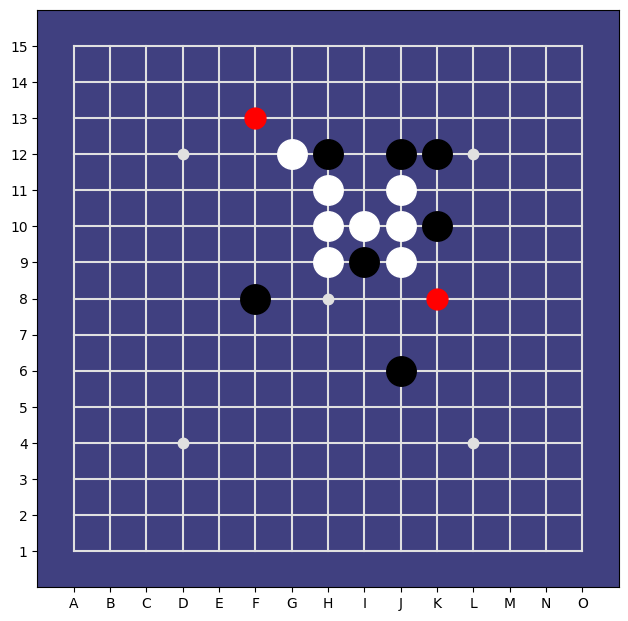

In [10]:
ds = curriculum[Focus.TERMINAL_THREAT]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Endgame

Next to play: BLACK
Value from BLACK's point of view: -0.887534499168396


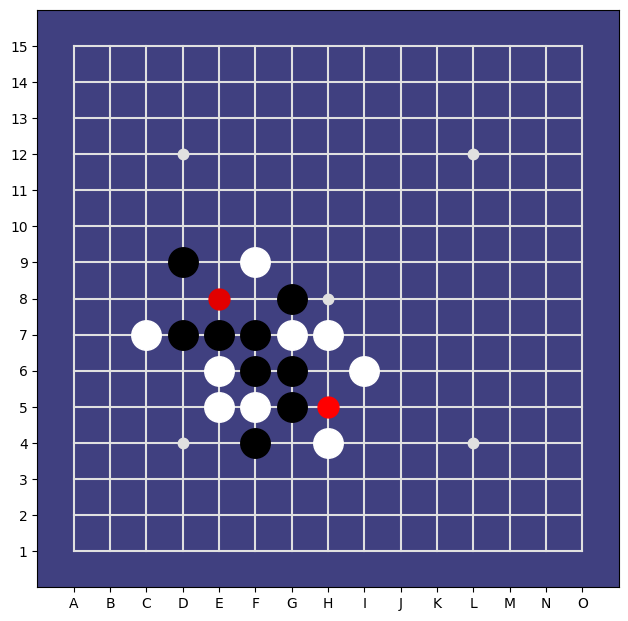

In [15]:
ds = curriculum[Focus.ENDGAME]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## General Gameplay

Next to play: WHITE
Value from WHITE's point of view: -0.9152462482452393


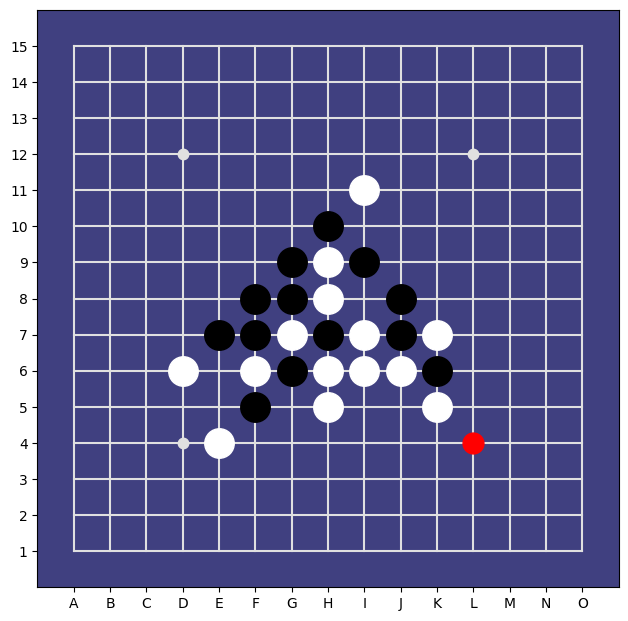

In [10]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

In [11]:
from aegomoku.utils import stones_from_example
stones, winner = stones_from_example(example)
from aegomoku.gomoku_board import GomokuBoard
board = GomokuBoard(15, stones)
board.plot()
from aegomoku.gomoku_game import GomokuGame
game = GomokuGame(15)
game.get_winner(board) or "No winner yet."

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  . [X] .  .  .  .  .  .    
10    .  .  .  .  .  .  .  O  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  O  X  O  .  .  .  .  .  .    
 8    .  .  .  .  .  O  O  X  .  O  .  .  .  .  .    
 7    .  .  .  .  O  O  X  O  X  O  X  .  .  .  .    
 6    .  .  .  X  .  X  O  X  X  X  O  .  .  .  .    
 5    .  .  .  .  .  O  .  X  .  .  X  .  .  .  .    
 4    .  .  .  .  X  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O


/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


'No winner yet.'

---

In [12]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 128)  46592       ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                      

In [13]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [17]:
ds = curriculum[Focus.ENDGAME]['dataset']
trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)

Epoch: 1, Training: p: 5.373364, v: 0.7047332 - elapsed: 76.751s
Epoch: 2, Training: p: 5.373487, v: 0.701011 - elapsed: 37.308s
Epoch: 3, Training: p: 5.373521, v: 0.6972485 - elapsed: 40.196s
Epoch: 4, Training: p: 5.373443, v: 0.6933641 - elapsed: 41.792s
Epoch: 5, Training: p: 5.37338, v: 0.689425 - elapsed: 38.179s
Epoch: 6, Training: p: 5.373328, v: 0.6855194 - elapsed: 37.173s



KeyboardInterrupt



In [19]:
filenames = ["trajectories/mcts/the_heuristic_200.pickle",
             "trajectories/policy/terminal_opportunities.pickle",
             "trajectories/policy/terminal_threats.pickle"]

# Number of training samples from each course
N_warmup = [1000, 1000, 1000]
N_main = [20000, 2000, 4000]

curriculum = [read_training_data(filename, BOARD_SIZE) for filename in filenames]
datasets_warmup = []
datasets_main = []
for i in range(len(filenames)):
    examples = curriculum[i]
    datasets_warmup.append(create_dataset(examples[:N_warmup[i]]))
    datasets_main.append(create_dataset(examples[:N_main[i]]))

for i, course in enumerate(curriculum):
    print(filenames[i])
    print(len(course), len(course[0]), course[0][0].shape)

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    1.414 1.414 1.414 1.414 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    1.414 2.646 2.236 2.646 2.236 1.414
 0.    0.    0.    0.    0.    0.    1.414 1.414 0.    0.    2.236 3.162
 3.162 2.646 1.414 0.    0.    0.    0.    0.    0.    1.414 2.646 0.
 1.414 0.    2.236 0.    2.646 2.236 0.    0.    0.    0.    0.    0.
 2.236 2.646 3.162 2.236 0.    1.414 2.236 2.646 1.414 0.    0.    0.
 0.    0.    0.    1.414 2.646 3.162 0.    2.236 0.    1.414 1.414 0.
 0.    0.    0.    0.    0.    0.    1.414 2.646 3.162 2.646 2.646 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.236 2.236
 2.236 2.236 1.414 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.  

KeyboardInterrupt: 

## A quick peek into the course material

trajectories/mcts/the_heuristic_200.pickle
Next to play: WHITE
Value from WHITE's point of view: -0.07604260914878462
trajectories/policy/terminal_opportunities.pickle
Next to play: BLACK
Value from BLACK's point of view: 0.9288062201386487
trajectories/policy/terminal_threats.pickle
Next to play: WHITE
Value from WHITE's point of view: -0.7951092100023196


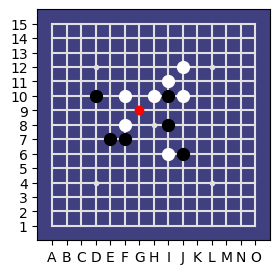

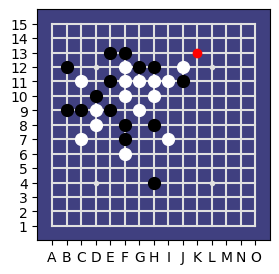

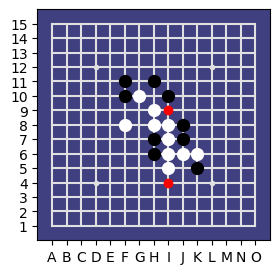

In [14]:
for i, course in enumerate(curriculum):
    print(filenames[i])
    analyse_example(BOARD_SIZE, course[random.randint(0, len(course))], disp_width=3)

---

# Construct a fresh model

In [97]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 128)  46592       ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                      

---


# Execute the curriculum
The idea here is to first teach the aspects of recognizing near-terminals in both directions: opportunities and threats.

Then mixing any other game position into the trainings to see the network improve on all subjects.

In [98]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [17]:
# Step one: understand almost-terminal positions
for i in range(10):
    print(f"Day {i+1}:")
    for ds in datasets_warmup[1:]:
        trainer.train(ds, epochs_per_train=10, report_every=None)

Day 1:


2022-08-28 15:39:49.663823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-28 15:39:49.910978: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch: 10, Training: (5.984689, 0.42564225)
Epoch: 10, Training: (4.93517, 1.6454499)
Day 2:
Epoch: 10, Training: (5.099399, 0.7660154)
Epoch: 10, Training: (5.1135254, 0.42240945)
Day 3:
Epoch: 10, Training: (5.095559, 0.7811626)
Epoch: 10, Training: (5.087858, 0.43281984)
Day 4:
Epoch: 10, Training: (5.063113, 0.7571993)
Epoch: 10, Training: (5.034372, 0.45303822)
Day 5:
Epoch: 10, Training: (4.9373207, 0.7252458)
Epoch: 10, Training: (4.802661, 0.49764395)
Day 6:
Epoch: 10, Training: (4.87271, 0.7239165)
Epoch: 10, Training: (4.6543207, 0.46893826)
Day 7:
Epoch: 10, Training: (4.3898616, 0.61984456)
Epoch: 10, Training: (4.331273, 0.8262342)
Day 8:
Epoch: 10, Training: (4.746413, 0.76040953)
Epoch: 10, Training: (4.534007, 0.4296605)
Day 9:
Epoch: 10, Training: (3.9880328, 0.7305903)
Epoch: 10, Training: (3.3189864, 0.50517625)
Day 10:
Epoch: 10, Training: (3.3612587, 0.7467879)
Epoch: 10, Training: (2.433451, 0.4450102)


In [19]:
# Step 2: mix in all other positions
for i in range(10):
    print(f"Day {i+1}:")
    for ds in datasets_warmup:
        trainer.train(ds, epochs_per_train=20, report_every=20)

Day 1:
Epoch: 20, Training: (2.9545174, 0.37637115)
Epoch: 20, Training: (2.2783313, 0.6314651)
Epoch: 20, Training: (1.5957326, 0.5706433)
Day 2:
Epoch: 20, Training: (2.583715, 0.37852105)
Epoch: 20, Training: (2.064467, 0.5933886)
Epoch: 20, Training: (1.4782984, 0.5794381)
Day 3:
Epoch: 20, Training: (2.5468936, 0.38018087)
Epoch: 20, Training: (1.8841041, 0.5721065)
Epoch: 20, Training: (1.4671216, 0.5783595)
Day 4:
Epoch: 20, Training: (2.5332785, 0.37902275)
Epoch: 20, Training: (1.8168484, 0.5695618)
Epoch: 20, Training: (1.3424422, 0.58094114)
Day 5:
Epoch: 20, Training: (2.4570355, 0.37900242)
Epoch: 20, Training: (1.6790651, 0.5693162)
Epoch: 20, Training: (1.270053, 0.5763603)
Day 6:
Epoch: 20, Training: (2.4121413, 0.37815952)
Epoch: 20, Training: (1.5680506, 0.5703819)
Epoch: 20, Training: (1.2108147, 0.57305735)
Day 7:
Epoch: 20, Training: (2.388958, 0.37695324)
Epoch: 20, Training: (1.4582207, 0.572131)
Epoch: 20, Training: (1.140311, 0.5720842)
Day 8:
Epoch: 20, Traini

---

In [22]:
## The full training

In [24]:
for i in range(5):
    print(f"Day {i+1}:")
    for ds in datasets_main:
        trainer.train(ds, epochs_per_train=20, report_every=None)

Day 1:
Epoch: 20, Training: (1.9103442, 0.14034212)
Epoch: 20, Training: (0.44540924, 0.48245272)
Epoch: 20, Training: (0.78295135, 0.13109705)
Day 2:
Epoch: 20, Training: (1.8499267, 0.088037685)
Epoch: 20, Training: (0.4131093, 0.0917298)
Epoch: 20, Training: (0.82444936, 0.20029807)
Day 3:
Epoch: 20, Training: (1.9201267, 0.08883932)
Epoch: 20, Training: (0.7045783, 0.09379841)
Epoch: 20, Training: (0.8149947, 0.13776222)
Day 4:
Epoch: 20, Training: (1.9129205, 0.085171014)
Epoch: 20, Training: (0.4212504, 0.0651084)
Epoch: 20, Training: (0.81880075, 0.27886462)
Day 5:
Epoch: 20, Training: (1.9625417, 0.088207014)
Epoch: 20, Training: (0.424814, 0.11423471)
Epoch: 20, Training: (0.84872854, 0.88825333)


---

# Performance on formerly unseen data

n=36011
Next to play: BLACK
Value from BLACK's point of view: 0.799886155502954
Next to play: BLACK
Value from BLACK's point of view: -0.408933162689209


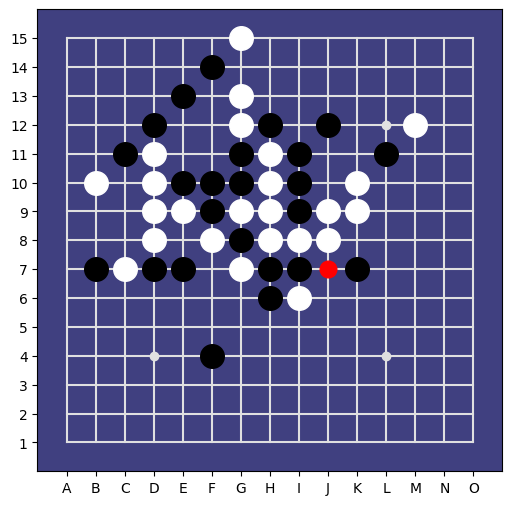

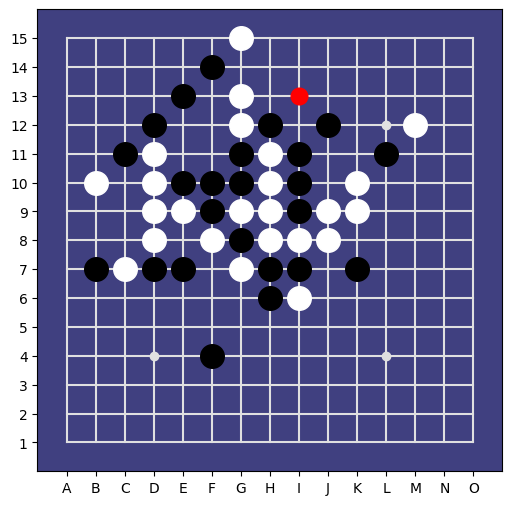

In [30]:
from aegomoku.utils import analyse_example
training_data = curriculum[0]

n = random.randint(N_main[0], len(training_data))
sample = np.expand_dims(training_data[n][0], axis=0).astype(float)

# Training Material
print(f"n={n}")
analyse_example(BOARD_SIZE, training_data[n])

# Learned
s, p, v = training_data[n]
p_learned, v_learned = model(sample)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned)